In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pylab as pl
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
# 1*1 population data, source: https://www.mortality.org/hmd/SWE/STATS/Population.txt
life_exp = pd.DataFrame(pd.read_csv('Population.txt', header=1, sep=r'\s{1,}'))[['Age', 'Year', 'Total']]
life_exp.rename(columns={'Total':'pop begin'}, inplace=True)
# 1*1 period life tables, source: https://www.mortality.org/hmd/SWE/STATS/bltper_1x1.txt
life_exp['ex'] = pd.DataFrame(pd.read_csv('bltper_1x1.txt', header=1, sep=r'\s{1,}')[['ex']])

life_exp['Age'] = life_exp['Age'].replace('110+', '110')
life_exp = life_exp.set_index(['Age', 'Year'])

ages = np.array(life_exp.index.get_level_values(0).unique())
years = np.array(life_exp.index.get_level_values(1).unique())

<ipython-input-2-3747503a74cf>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  life_exp = pd.DataFrame(pd.read_csv('Population.txt', header=1, sep=r'\s{1,}'))[['Age', 'Year', 'Total']]
<ipython-input-2-3747503a74cf>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  life_exp['ex'] = pd.DataFrame(pd.read_csv('bltper_1x1.txt', header=1, sep=r'\s{1,}')[['ex']])


In [3]:
# 1*1 death data, source: https://www.mortality.org/hmd/SWE/STATS/Deaths_1x1.txt
life_exp['Deaths'] = pd.DataFrame(pd.read_csv('Deaths_1x1.txt', header=1, sep=r'\s{1,}').set_index(['Age', 'Year']))['Total']
life_exp['Deaths'] = life_exp['Deaths'].replace(np.nan, 0)

<ipython-input-3-e340edca8c44>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  life_exp['Deaths'] = pd.DataFrame(pd.read_csv('Deaths_1x1.txt', header=1, sep=r'\s{1,}').set_index(['Age', 'Year']))['Total']


In [4]:
life_exp = life_exp.reset_index().set_index(['Year', 'Age'])
#combine >100 rows into 100 row
for year in years:
    # assume ex (remaining life expectancy) for 100+ is weighted average of >100 rows
    life_exp['ex'].loc[year, '100'] = (life_exp.loc[year].iloc[-11:]['ex'] * life_exp.loc[year].iloc[-11:]['pop begin']).sum()/(life_exp.loc[year].iloc[-11:]['pop begin'].sum())
    life_exp['pop begin'].loc[year, '100'] = life_exp.loc[year,'pop begin'].iloc[-11:].sum()
    life_exp['Deaths'].loc[year, '100'] = life_exp.loc[year,'Deaths'].iloc[-11:].sum()
    
#drop ages over 100
life_exp = life_exp.reset_index().set_index(['Age', 'Year']).drop(['101', '102', '103', '104', '105', '106', '107', '108', '109', '110'])
ages = np.array(life_exp.index.get_level_values(0).unique())


<ipython-input-4-12aba07195df>:5: RuntimeWarning: invalid value encountered in double_scalars
  life_exp['ex'].loc[year, '100'] = (life_exp.loc[year].iloc[-11:]['ex'] * life_exp.loc[year].iloc[-11:]['pop begin']).sum()/(life_exp.loc[year].iloc[-11:]['pop begin'].sum())
/home/rob/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [5]:
# 2020 1*1 deaths, source: https://www.statistikdatabasen.scb.se/pxweb/en/ssd/START__BE__BE0101__BE0101I/DodaHandelseK/table/tableViewLayout1/
deaths_age = pd.read_csv('BE0101D9_20210222-170839.csv')
deaths_age['Year'] = 2020
deaths_age = deaths_age.reset_index().rename(columns={'index':'Age', '2020':'Deaths'})
deaths_age['Age'] = deaths_age['Age'].astype(str)
deaths_age = deaths_age.set_index(['Age','Year']).loc[:,['Deaths']]

life_exp = life_exp.reset_index().set_index('Year')
life_exp['Deaths'].loc[2020] = deaths_age.values.reshape(-1)

/home/rob/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [6]:
# end of 2020 (approx beginning of 2021) population data, source: https://www.statistikdatabasen.scb.se/pxweb/en/ssd/START__BE__BE0101__BE0101A/BefolkningNy/table/tableViewLayout1/
pop_2021 = pd.DataFrame(pd.read_csv('BE0101N1_20210228-210005.csv')['2020'])
pop_2021.rename(columns={'2020':'pop begin'}, inplace=True)
pop_2021['Year'] = 2021
pop_2021['Age'] = ages
pop_2021.set_index('Year', inplace=True)
life_exp = pd.concat([life_exp, pop_2021])

In [7]:
life_exp = life_exp.reset_index().set_index(['Age'])
life_exp['pop'] = np.nan
#assume mid-year population is average of population at beginning and end of year
for age in ages:
    life_exp['pop'].loc[age] = pd.concat([pd.DataFrame(life_exp.loc[age]['pop begin']), pd.DataFrame(life_exp.loc[age]['pop begin'].shift(-1))], axis=1).mean(axis=1).values

In [8]:
life_exp = life_exp.reset_index().set_index(['Year'])
life_exp = life_exp.drop(2021) 


In [9]:
life_exp = life_exp.reset_index().set_index(['Age', 'Year'])

# life exp missing for 2020, predict by extrapolating from 4 year trendline
for age in ages:
    four_year_data = life_exp.loc[age, 'ex'].iloc[-5:-1]
    reg = LinearRegression().fit(np.array(four_year_data.index).reshape(-1,1), four_year_data.values.reshape(-1,1))
    life_exp['ex'].loc[age, 2020] = reg.predict(np.array([[2020]]))
    
years = np.array(life_exp.index.get_level_values(1).unique())

In [10]:
life_exp['death rates'] = life_exp['Deaths']/life_exp['pop']
life_exp['death rates'].loc['100', 1811] = life_exp['death rates'].loc['100', 1810] # 1811 had no population >=100, so copy death rate from pervious year
life_exp['pop'].loc['100', 1811] = life_exp['pop'].loc['100', 1810]
life_exp['ex'].loc['100', 1811] = life_exp['ex'].loc['100', 1810] # 1811 had no population >=100, so copy death rate from pervious year


In [11]:
life_exp = life_exp.reset_index().set_index('Year')
life_exp['standard pop'] = np.nan

# use 2018 as reference year for age adjustment
for year in years:
    life_exp.loc[year]['standard pop'] = np.array(life_exp.loc[2018]['pop'])

life_exp['adjusted deaths'] =  life_exp['standard pop'] * life_exp['death rates']


<ipython-input-11-9c3ed3321eb8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  life_exp.loc[year]['standard pop'] = np.array(life_exp.loc[2018]['pop'])


In [12]:
life_exp = life_exp.reset_index().set_index(['Age', 'Year'])
# assign age ranges (0-19, 20-39, etc.)
life_exp['Age range'] = np.array(((life_exp.reset_index()['Age'].astype(float) // 20) * 20).apply(lambda x: (str(int(x)) + '-' + str(int(x) +19)) if x<80 else '80+'))

#sum over all ages for each year
life_exp_agg = life_exp.reset_index().set_index('Age').groupby('Year').agg({'Deaths':np.sum, 'pop':np.sum, 'standard pop':np.sum, 'adjusted deaths':np.sum})
life_exp_agg['deaths per million'] = life_exp_agg['Deaths']/(life_exp_agg['pop']/1000000)

In [13]:
# aggregate data by age range
df_age_range = life_exp.groupby(['Year', 'Age range']).agg({'Deaths':np.sum, 'pop':np.sum, 'adjusted deaths':np.sum, 'standard pop':np.sum}).reset_index()
deaths_age_range = df_age_range.pivot(index='Year', columns='Age range', values='Deaths')
deaths_age_range.columns = ['deaths ' + str(col) for col in deaths_age_range.columns]

pop_age = df_age_range.pivot(index='Year', columns='Age range', values='pop')
pop_age.columns = ['pop ' + str(col) for col in pop_age.columns]


adjusted_deaths_age_range = df_age_range.pivot(index='Year', columns='Age range', values='adjusted deaths')
adjusted_deaths_age_range.columns = ['adjusted deaths ' + str(col) for col in adjusted_deaths_age_range.columns]

standard_pop_age = df_age_range.pivot(index='Year', columns='Age range', values='standard pop')
standard_pop_age.columns = ['standard pop ' + str(col) for col in pop_age.columns]

life_exp_agg = pd.concat([life_exp_agg,deaths_age_range, pop_age, adjusted_deaths_age_range, standard_pop_age], axis=1)

In [14]:
from statsmodels.tsa.seasonal import STL
life_exp['predicted death rates'] = np.nan
period=8

# apply STL to find "predicted" death rates
for age in ages:
    stl = STL(life_exp.loc[age, 'death rates'], period=period, robust=True)
    res = stl.fit().trend
    life_exp['predicted death rates'].loc[age] =  np.array(res)

/home/rob/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


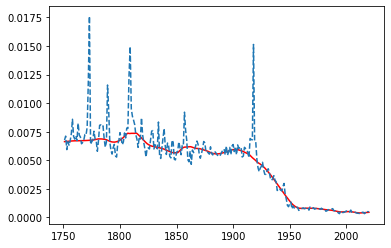

In [15]:
#comparing smoothed vs actual
plt.plot((life_exp.loc['20', 'predicted death rates']), color='red')
plt.plot(life_exp.loc['20', 'death rates'], linestyle='--')

In [16]:
life_exp['predicted deaths'] = life_exp['pop'] * life_exp['predicted death rates']
life_exp['predicted adjusted deaths'] = life_exp['standard pop'] * life_exp['predicted death rates']

In [17]:
life_exp_agg['predicted deaths'] = life_exp.reset_index().set_index('Age').groupby('Year').agg({'predicted deaths': np.sum})
life_exp_agg['predicted deaths per million'] = life_exp_agg['predicted deaths']/(life_exp_agg['pop']/1000000)

life_exp_agg['predicted adjusted deaths'] = life_exp.reset_index().set_index('Age').groupby('Year').agg({'predicted adjusted deaths': np.sum})
life_exp_agg['predicted adjusted deaths per million'] = life_exp_agg['predicted adjusted deaths']/(life_exp_agg['standard pop']/1000000)

In [18]:
life_exp['excess deaths'] = life_exp['Deaths'] - life_exp['predicted deaths']
life_exp_agg['excess deaths'] = life_exp.reset_index().set_index('Age').groupby('Year').agg({'excess deaths': np.sum})
life_exp_agg['excess deaths per million'] = life_exp_agg['excess deaths']/(life_exp_agg['pop']/1000000)
life_exp_agg['percentage excess'] = life_exp_agg['excess deaths per million']*100/life_exp_agg['predicted deaths per million']

In [19]:
life_exp['excess adjusted deaths'] = life_exp['adjusted deaths'] - life_exp['predicted adjusted deaths']
life_exp_agg['excess adjusted deaths'] = life_exp.reset_index().set_index('Age').groupby('Year').agg({'excess adjusted deaths': np.sum})
life_exp_agg['excess adjusted deaths per million'] = life_exp_agg['excess adjusted deaths']/(life_exp_agg['standard pop']/1000000)
life_exp_agg['percentage excess adjusted'] = life_exp_agg['excess adjusted deaths per million']*100/life_exp_agg['predicted adjusted deaths per million']

In [20]:
df_age_range = life_exp.groupby(['Year', 'Age range']).agg({'predicted deaths':np.sum}).reset_index()

predicted_deaths_age_range = df_age_range.pivot(index='Year', columns='Age range', values='predicted deaths')
predicted_deaths_age_range.columns = ['predicted ' + str(col) for col in deaths_age_range.columns]

life_exp_agg = pd.concat([life_exp_agg,predicted_deaths_age_range], axis=1)

In [21]:
df_age_range = life_exp.groupby(['Year', 'Age range']).agg({'predicted adjusted deaths':np.sum}).reset_index()

predicted_adjusted_deaths_age = df_age_range.pivot(index='Year', columns='Age range', values='predicted adjusted deaths')
predicted_adjusted_deaths_age.columns = ['predicted ' + str(col) for col in predicted_adjusted_deaths_age.columns]

life_exp_agg = pd.concat([life_exp_agg,predicted_adjusted_deaths_age], axis=1)

In [22]:
# smooth to get "predicted" remaining life expectancy
life_exp['ex predicted'] = np.nan
for age in ages:
    stl = STL(life_exp.loc[age, 'ex'], period=period, robust=True)
    res = stl.fit().trend
    life_exp['ex predicted'].loc[age] =  np.array(res)
    
life_exp['life years lost'] = life_exp['Deaths'] * life_exp['ex predicted']
life_exp['predicted life years lost'] = life_exp['predicted deaths'] * life_exp['ex predicted']
life_exp['adjusted life years lost'] =  life_exp['adjusted deaths'] * life_exp['ex']

life_exp_agg['life years lost'] = life_exp.reset_index().set_index('Age').groupby('Year').agg({'life years lost': np.sum})
life_exp_agg['life years lost per 1000'] = life_exp_agg['life years lost']/(life_exp_agg['pop']/1000)
life_exp_agg['life years lost/death'] = life_exp_agg['life years lost']/life_exp_agg['Deaths']

life_exp_agg['predicted life years lost'] = life_exp.reset_index().set_index('Age').groupby('Year').agg({'predicted life years lost': np.sum})
life_exp_agg['predicted life years lost per 1000'] = life_exp_agg['predicted life years lost']/(life_exp_agg['pop']/1000)


In [23]:
life_exp['excess life years lost'] = life_exp['life years lost'] - life_exp['predicted life years lost']
life_exp_agg['excess life years lost'] = life_exp.reset_index().set_index('Age').groupby('Year').agg({'excess life years lost': np.sum})
life_exp_agg['excess life years lost per 1000'] = life_exp_agg['excess life years lost']/(life_exp_agg['pop']/1000)
life_exp_agg['percentage excess life years lost per 1000'] = life_exp_agg['excess life years lost per 1000']*100/life_exp_agg['predicted life years lost per 1000']


(-6.44, 126.44)
(0.0, 18906.569784897958)


<ipython-input-24-32cfe78d8280>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(a)
<ipython-input-24-32cfe78d8280>:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_yticklabels(a)


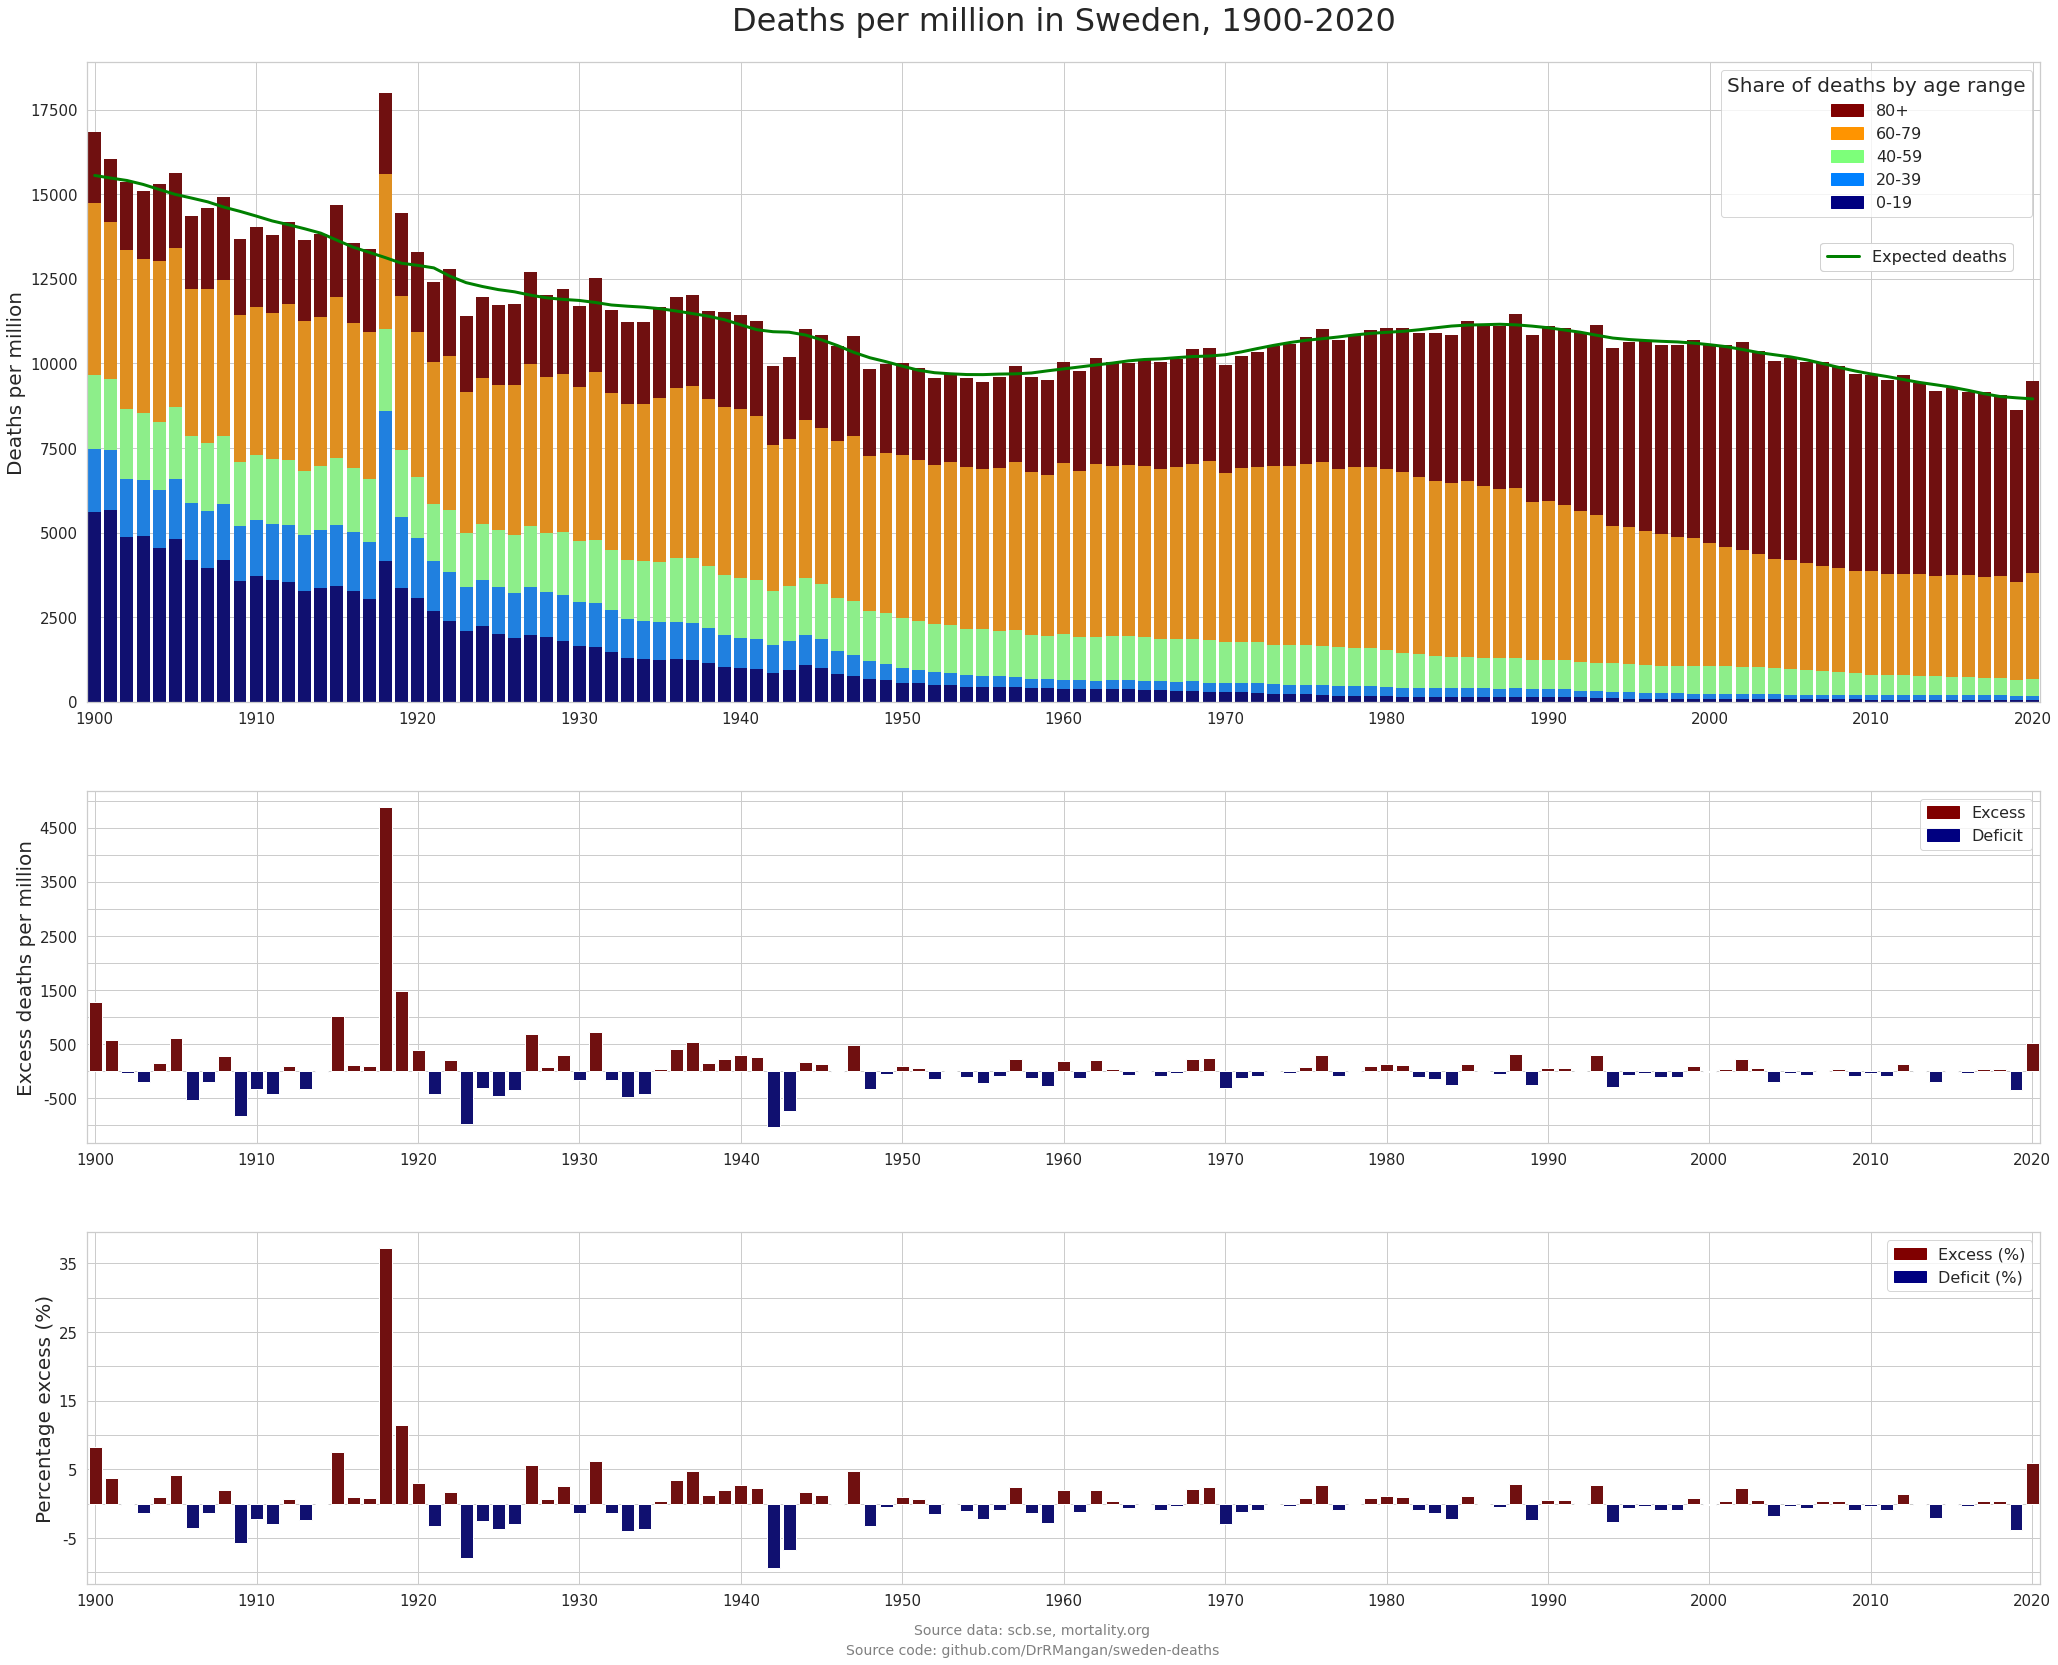

In [24]:


sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(3,1, gridspec_kw={'height_ratios': [2, 1.1, 1.1]}, figsize = (35,28))

n = 5
colors = pl.cm.jet(np.linspace(0,1,n))

#start = -len(years)
start = -121

death_list = [life_exp_agg['deaths 0-19'].iloc[start:], life_exp_agg['deaths 20-39'].iloc[start:], life_exp_agg['deaths 40-59'].iloc[start:], life_exp_agg['deaths 60-79'].iloc[start:], life_exp_agg['deaths 80+'].iloc[start:]]

for d in range(len(death_list), 0, -1):
    axs[0] = sns.barplot(x=years[start:], y=sum(death_list[:d])/(life_exp_agg['pop'].iloc[start:]/1000000), color=colors[d-1], ax=axs[0])


line1 = axs[0].plot(np.arange(0,-start,1), life_exp_agg[ 'predicted deaths per million'].iloc[start:], linewidth=3, color='green', label='Expected deaths')

red_patch = mpatches.Patch(color=colors[4], label='80+')
orange_patch = mpatches.Patch(color=colors[3], label='60-79')
green_patch = mpatches.Patch(color=colors[2], label='40-59')
blue_patch = mpatches.Patch(color=colors[1], label='20-39')
blue2_patch = mpatches.Patch(color=colors[0], label='0-19')

legend1 = axs[0].legend(handles=[red_patch,orange_patch, green_patch, blue_patch, blue2_patch], title='Share of deaths by age range', title_fontsize=20, fontsize=16)
axs[0].add_artist(legend1)

legend2 = axs[0].legend(handles=line1, fontsize=16, loc=1, bbox_to_anchor=(0.99,0.73))
axs[0].add_artist(legend2)

axs[0].xaxis.grid(True) # Show the vertical gridlines


axs[0].set_title('Deaths per million in Sweden, 1900-2020', fontsize=32, y=1.04)
axs[0].set_ylabel('Deaths per million', fontsize=20)
axs[0].tick_params(axis='both', labelsize=15)

from matplotlib.ticker import MultipleLocator
axs[0].yaxis.set_major_locator(MultipleLocator(2500))

plt.setp(axs[0].patches, linewidth=0)
axs[0].xaxis.set_major_locator(MultipleLocator(10))

def add_margin(ax,x=0.05,y=0.05):
    # This will, by default, add 5% to the x and y margins. You 
    # can customise this using the x and y arguments when you call it.

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xmargin = (xlim[1]-xlim[0])*x
    ymargin = (ylim[1]-ylim[0])*y

    ax.set_xlim(xlim[0]-xmargin,xlim[1]+xmargin)
    ax.set_ylim(ylim[0]-ymargin,ylim[1]+ymargin)
x0,y0=axs[0].get_xlim(),axs[0].get_ylim()
print(x0)
print(y0)

# Update the limits using set_xlim and set_ylim
add_margin(axs[0],x=-0.045,y=0) 


colors2 = [colors[-1] if c >= 0 else colors[0] for c in life_exp_agg['excess deaths per million'].iloc[start:].to_list()]
axs[1].tick_params(axis='both', labelsize=15)
axs[1] = sns.barplot(x=years[start:], y=life_exp_agg['excess deaths per million'].iloc[start:], ax=axs[1], palette=colors2)
axs[1].set_ylabel('Excess deaths per million', fontsize=20)
axs[1].set_xticklabels(axs[1].get_xticklabels())
axs[1].xaxis.grid(True)
axs[1].xaxis.set_major_locator(MultipleLocator(10))
axs[1].yaxis.set_major_locator(MultipleLocator(500))
red_patch = mpatches.Patch(color=colors[4], label='Excess')
blue2_patch = mpatches.Patch(color=colors[0], label='Deficit')
axs[1].legend(handles=[red_patch, blue2_patch],  title_fontsize=20, fontsize=16)

a=axs[1].get_yticks().tolist()
a= list(map(int, a))
a[1::2] =' '*len(a[1::2])
axs[1].set_yticklabels(a)


colors2 = [colors[-1] if c >= 0 else colors[0] for c in life_exp_agg['percentage excess'].iloc[start:].to_list()]
axs[2].tick_params(axis='both', labelsize=15)
axs[2] = sns.barplot(x=years[start:], y=life_exp_agg['percentage excess'].iloc[start:], ax=axs[2], palette=colors2)
axs[2].set_ylabel('Percentage excess (%)', fontsize=20)
axs[2].set_xticklabels(axs[2].get_xticklabels())
axs[2].xaxis.grid(True)
axs[2].xaxis.set_major_locator(MultipleLocator(10))
axs[2].yaxis.set_major_locator(MultipleLocator(5))
red_patch = mpatches.Patch(color=colors[4], label='Excess (%)')
blue2_patch = mpatches.Patch(color=colors[0], label='Deficit (%)')
axs[2].legend(handles=[red_patch, blue2_patch],  title_fontsize=20, fontsize=16)
a=axs[2].get_yticks().tolist()
a= list(map(int, a))
a[1::2] =' '*len(a[1::2])
axs[2].set_yticklabels(a)


sns.set_style("ticks")

plt.figtext(0.5, 0.1, "Source data: scb.se, mortality.org", color='gray', ha="center", fontsize=14)
plt.figtext(0.5, 0.09, "Source code: github.com/DrRMangan/sweden-deaths", color='gray', ha="center", fontsize=14)

plt.show()



fig.savefig('sweden1.png', bbox_inches='tight')

(-6.44, 126.44)
(0.0, 32154.72105343167)


<ipython-input-25-a149a86751e0>:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(a)
<ipython-input-25-a149a86751e0>:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_yticklabels(a)


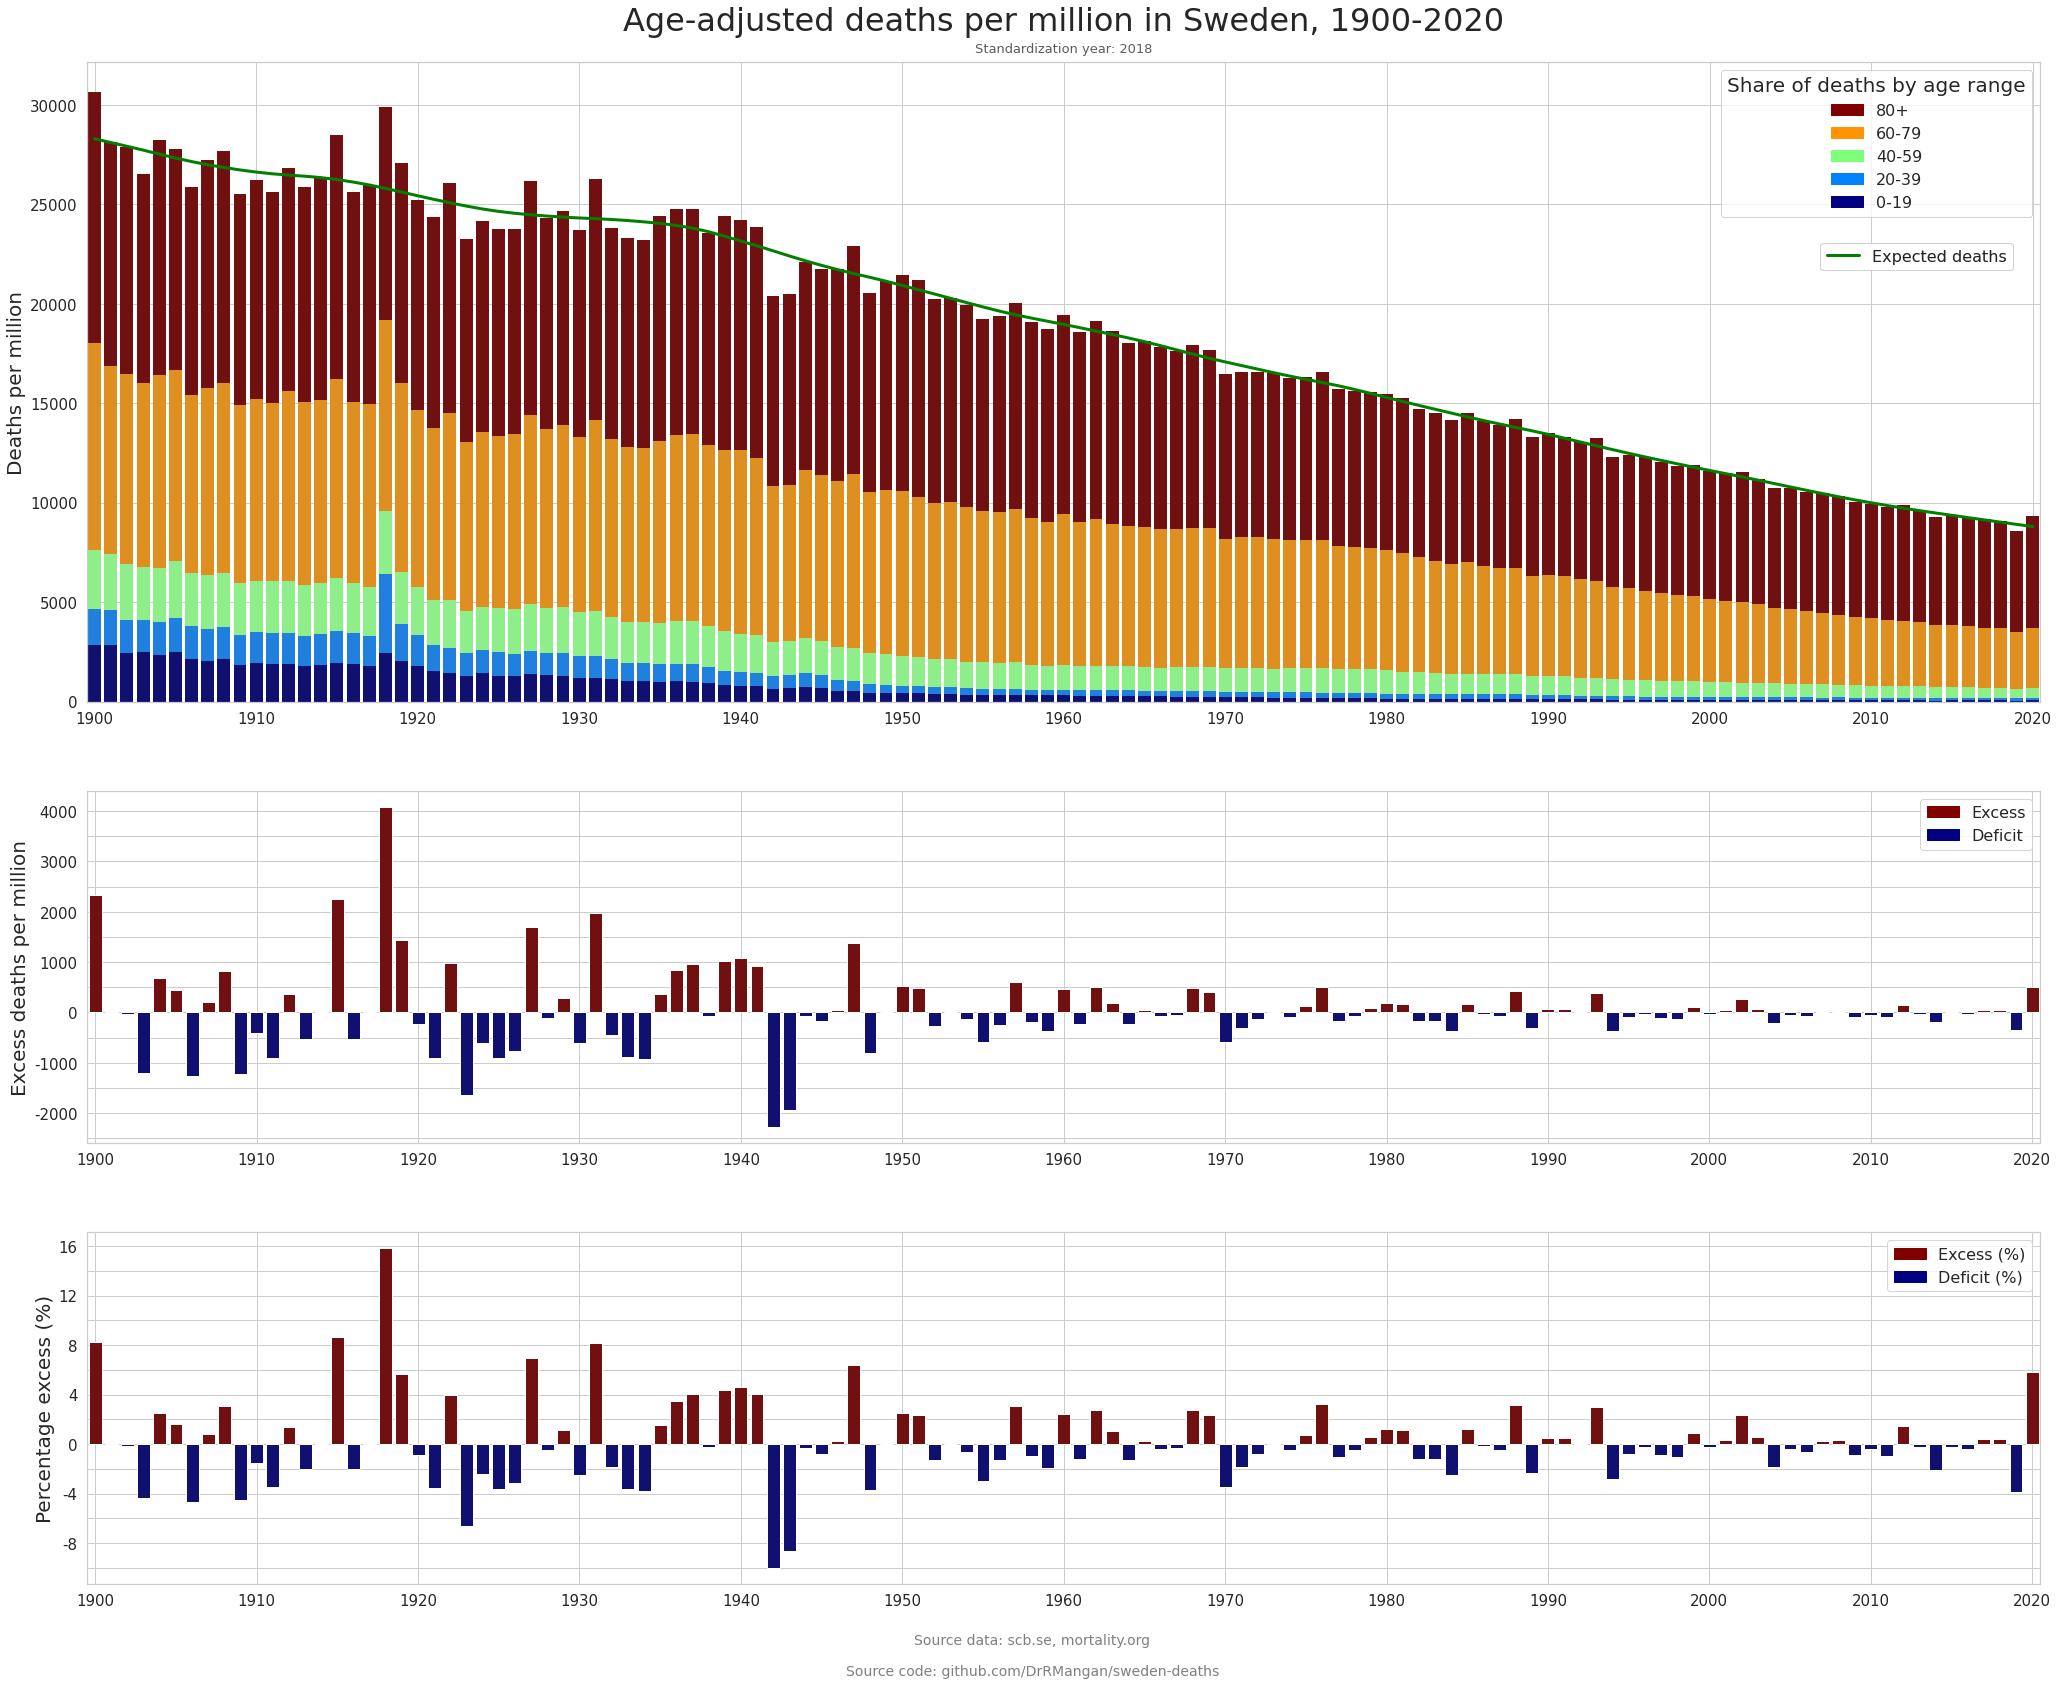

In [25]:


sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(3,1, gridspec_kw={'height_ratios': [2, 1.1, 1.1]}, figsize = (35,28))

n = 5
colors = pl.cm.jet(np.linspace(0,1,n))

#start = -len(years)
start = -121

death_list = [life_exp_agg['adjusted deaths 0-19'].iloc[start:], life_exp_agg['adjusted deaths 20-39'].iloc[start:], life_exp_agg['adjusted deaths 40-59'].iloc[start:], life_exp_agg['adjusted deaths 60-79'].iloc[start:], life_exp_agg['adjusted deaths 80+'].iloc[start:]]

for d in range(len(death_list), 0, -1):
    axs[0] = sns.barplot(x=years[start:], y=sum(death_list[:d])/(life_exp_agg['standard pop'].iloc[start:]/1000000), color=colors[d-1], ax=axs[0])


line1 = axs[0].plot(np.arange(0,-start,1), life_exp_agg[ 'predicted adjusted deaths per million'].iloc[start:], linewidth=3, color='green', label='Expected deaths')

red_patch = mpatches.Patch(color=colors[4], label='80+')
orange_patch = mpatches.Patch(color=colors[3], label='60-79')
green_patch = mpatches.Patch(color=colors[2], label='40-59')
blue_patch = mpatches.Patch(color=colors[1], label='20-39')
blue2_patch = mpatches.Patch(color=colors[0], label='0-19')

legend1 = axs[0].legend(handles=[red_patch,orange_patch, green_patch, blue_patch, blue2_patch], title='Share of deaths by age range', title_fontsize=20, fontsize=16)
axs[0].add_artist(legend1)

axs[0].xaxis.grid(True) # Show the vertical gridlines

legend2 = axs[0].legend(handles=line1, fontsize=16, loc=1, bbox_to_anchor=(0.99,0.73))
axs[0].add_artist(legend2)

axs[0].set_title('Age-adjusted deaths per million in Sweden, 1900-2020', fontsize=32, y=1.04)
axs[0].set_ylabel('Deaths per million', fontsize=20)
axs[0].tick_params(axis='both', labelsize=15)

from matplotlib.ticker import MultipleLocator
axs[0].yaxis.set_major_locator(MultipleLocator(5000))

plt.setp(axs[0].patches, linewidth=0)
axs[0].xaxis.set_major_locator(MultipleLocator(10))

axs[0].text(x=0.5, y=1.01, s='Standardization year: 2018', fontsize=13, alpha=0.75, ha='center', va='bottom', transform=axs[0].transAxes)


x0,y0=axs[0].get_xlim(),axs[0].get_ylim()
print(x0)
print(y0)

# Update the limits using set_xlim and set_ylim
add_margin(axs[0],x=-0.045,y=0) 

sns.set_style("ticks")

colors2 = [colors[-1] if c >= 0 else colors[0] for c in life_exp_agg['excess adjusted deaths per million'].iloc[start:].to_list()]
axs[1].tick_params(axis='both', labelsize=15)
axs[1] = sns.barplot(x=years[start:], y=life_exp_agg['excess adjusted deaths per million'].iloc[start:], ax=axs[1], palette=colors2)
axs[1].set_ylabel('Excess deaths per million', fontsize=20)
axs[1].set_xticklabels(axs[1].get_xticklabels())
axs[1].xaxis.grid(True)
axs[1].xaxis.set_major_locator(MultipleLocator(10))
axs[1].yaxis.set_major_locator(MultipleLocator(500))
red_patch = mpatches.Patch(color=colors[4], label='Excess')
blue2_patch = mpatches.Patch(color=colors[0], label='Deficit')
axs[1].legend(handles=[red_patch, blue2_patch],  title_fontsize=20, fontsize=16)

a=axs[1].get_yticks().tolist()
a= list(map(int, a))
a[1::2] =' '*len(a[1::2])
axs[1].set_yticklabels(a)


colors2 = [colors[-1] if c >= 0 else colors[0] for c in life_exp_agg['percentage excess adjusted'].iloc[start:].to_list()]
axs[2].tick_params(axis='both', labelsize=15)
axs[2] = sns.barplot(x=years[start:], y=life_exp_agg['percentage excess adjusted'].iloc[start:], ax=axs[2], palette=colors2)
axs[2].set_ylabel('Percentage excess (%)', fontsize=20)
axs[2].set_xticklabels(axs[2].get_xticklabels())
axs[2].xaxis.grid(True)
axs[2].xaxis.set_major_locator(MultipleLocator(10))
axs[2].yaxis.set_major_locator(MultipleLocator(2))
red_patch = mpatches.Patch(color=colors[4], label='Excess (%)')
blue2_patch = mpatches.Patch(color=colors[0], label='Deficit (%)')
axs[2].legend(handles=[red_patch, blue2_patch],  title_fontsize=20, fontsize=16)
a=axs[2].get_yticks().tolist()
a= list(map(int, a))
a[1::2] =' '*len(a[1::2])
axs[2].set_yticklabels(a)



plt.figtext(0.5, 0.095, "Source data: scb.se, mortality.org", color='gray', ha="center", fontsize=14)
plt.figtext(0.5, 0.08, "Source code: github.com/DrRMangan/sweden-deaths", color='gray', ha="center", fontsize=14)

plt.show()



fig.savefig('sweden2.png', bbox_inches='tight')

<ipython-input-26-df080293cadb>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(a)


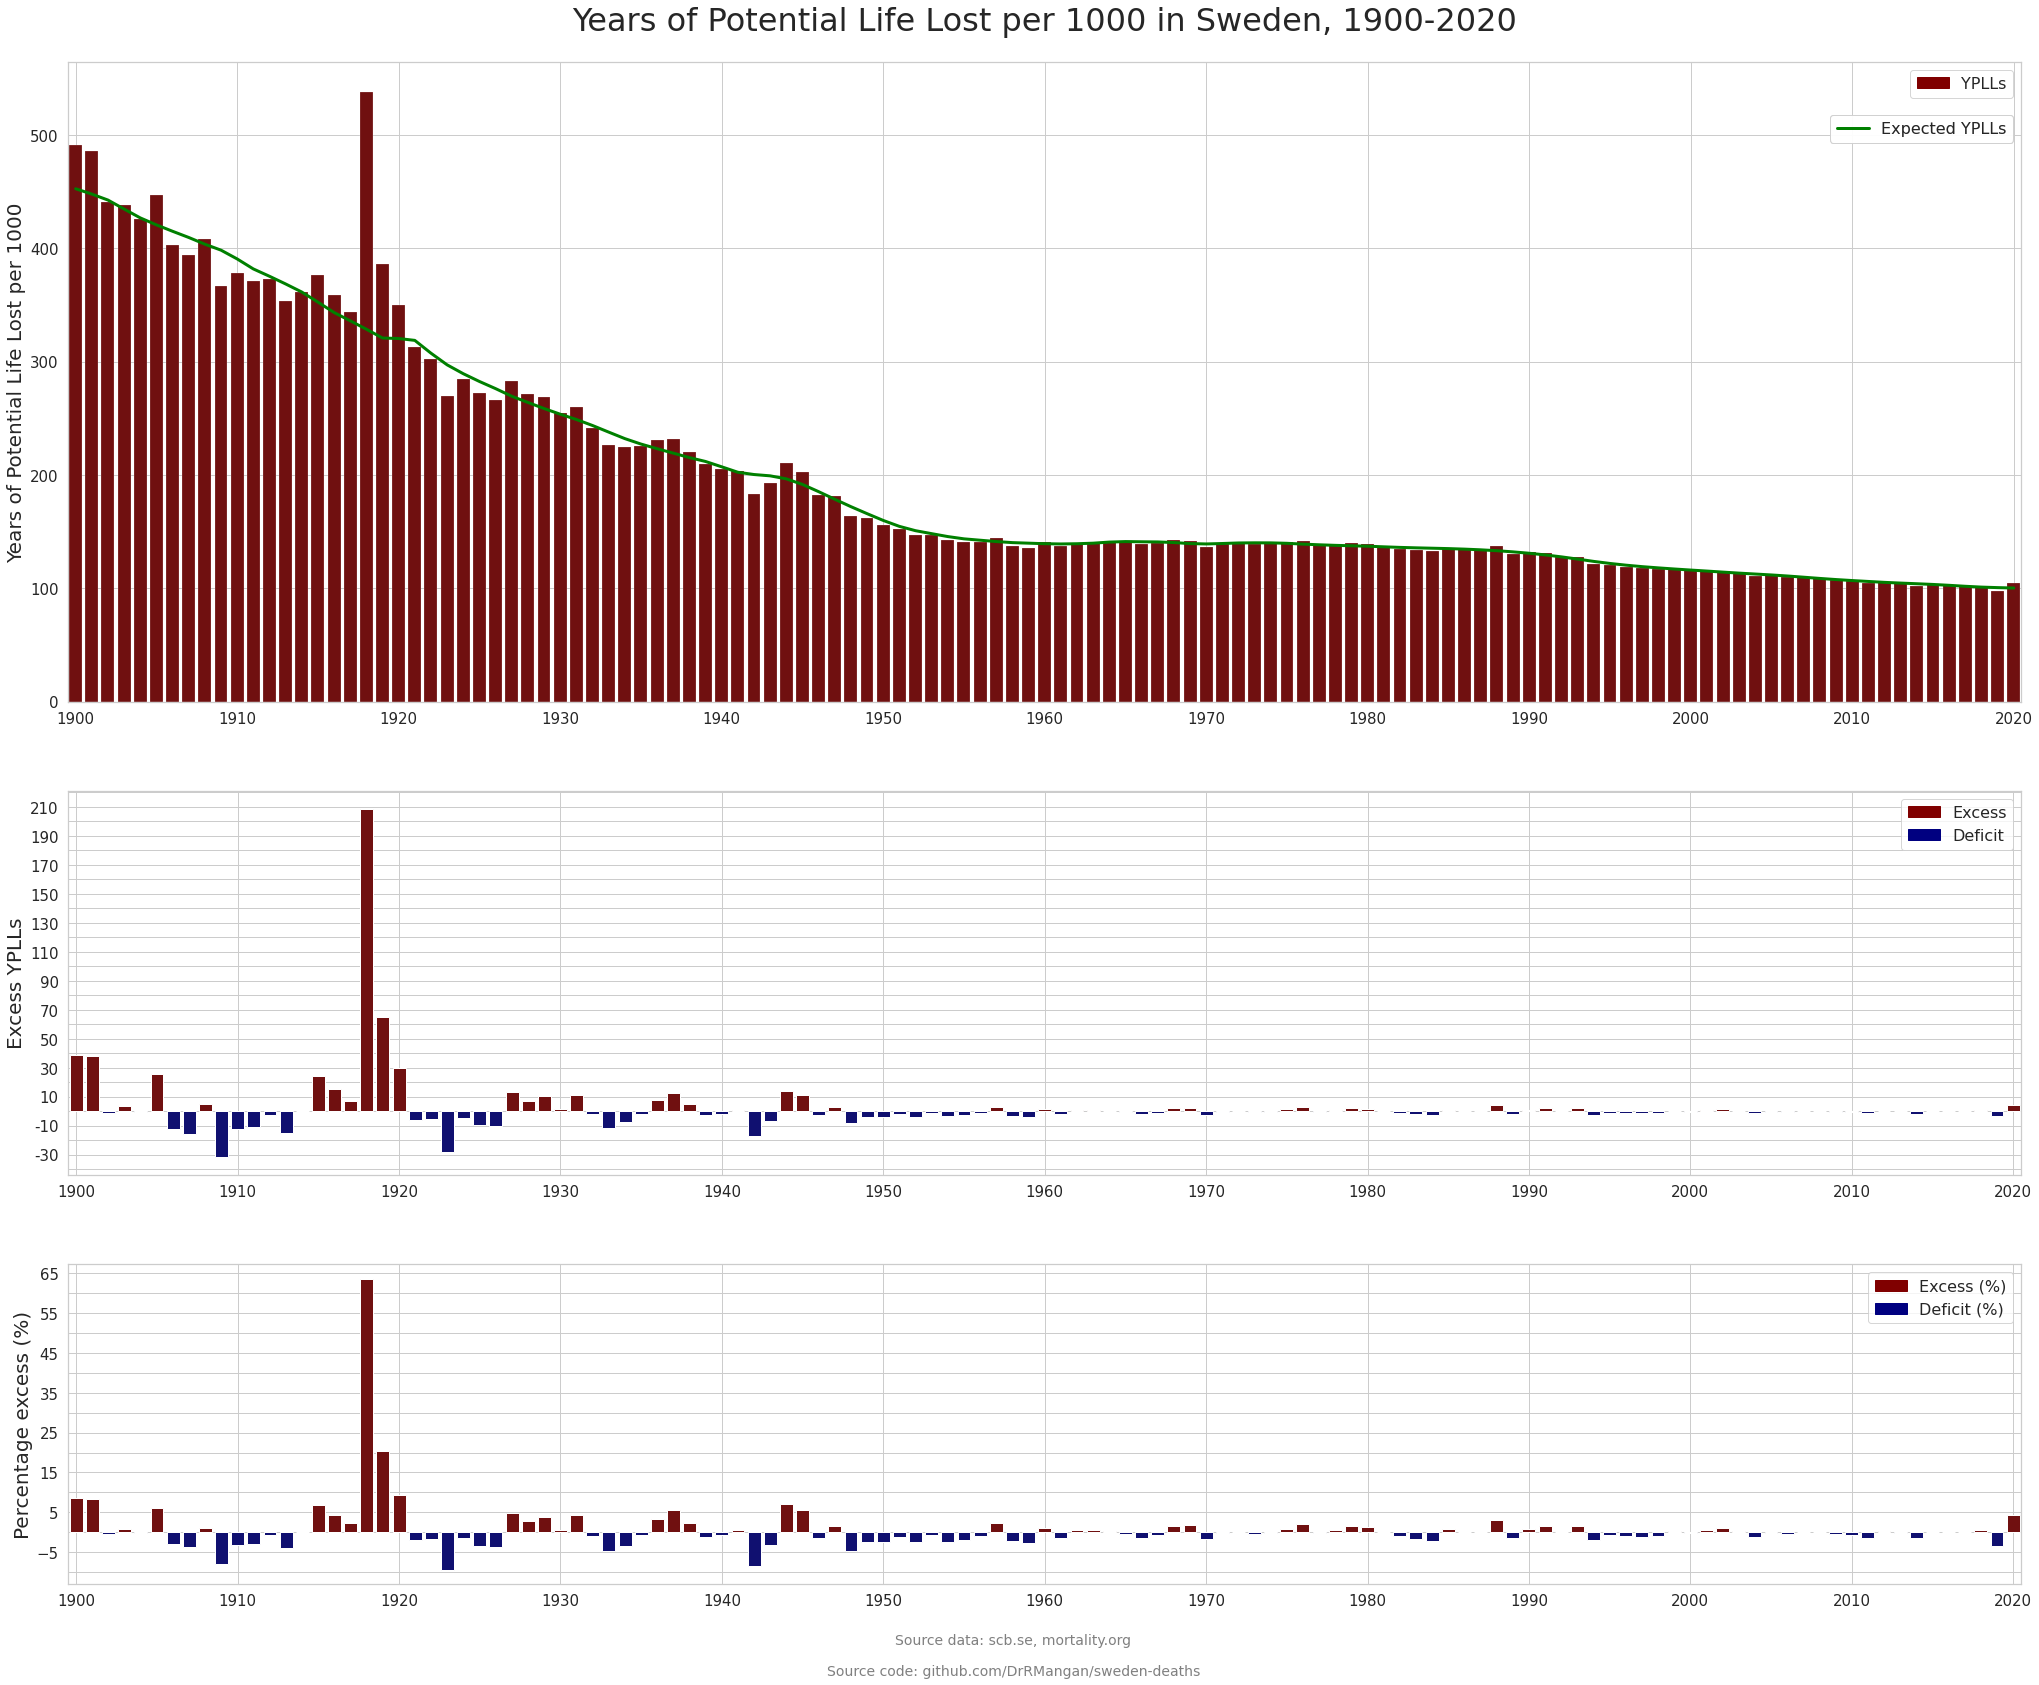

In [26]:


sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(3,1, gridspec_kw={'height_ratios': [2, 1.2, 1]}, figsize = (35,28))

n = 5
colors = pl.cm.jet(np.linspace(0,1,n))

#start = -len(years)
start = -121

axs[0] = sns.barplot(x=years[start:], y=life_exp_agg['life years lost per 1000'].iloc[start:], ax=axs[0], color=colors[-1])

red_patch = mpatches.Patch(color=colors[4], label='YPLLs')
legend1 = axs[0].legend(handles=[red_patch], fontsize=16)
axs[0].add_artist(legend1)


line1 = axs[0].plot(np.arange(0,-start,1), life_exp_agg[ 'predicted life years lost per 1000'].iloc[start:], linewidth=3, color='green', label='Expected YPLLs')
legend2 = axs[0].legend(handles=line1, fontsize=16, loc=1, bbox_to_anchor=(1,0.93))
axs[0].add_artist(legend2)

axs[0].xaxis.grid(True) # Show the vertical gridlines


axs[0].set_title('Years of Potential Life Lost per 1000 in Sweden, 1900-2020', fontsize=32, y=1.04)
axs[0].set_ylabel('Years of Potential Life Lost per 1000', fontsize=20)
axs[0].tick_params(axis='both', labelsize=15)

from matplotlib.ticker import MultipleLocator
axs[0].yaxis.set_major_locator(MultipleLocator(100))

plt.setp(axs[0].patches, linewidth=0.2)
axs[0].xaxis.set_major_locator(MultipleLocator(10))

# Update the limits using set_xlim and set_ylim
add_margin(axs[0],x=-0.045,y=0) 

sns.set_style("ticks")


colors2 = [colors[-1] if c >= 0 else colors[0] for c in life_exp_agg['excess life years lost per 1000'].iloc[start:].to_list()]
axs[1].tick_params(axis='both', labelsize=15)
axs[1] = sns.barplot(x=years[start:], y=life_exp_agg['excess life years lost per 1000'].iloc[start:], ax=axs[1], palette=colors2)
axs[1].set_ylabel('Excess YPLLs', fontsize=20)
axs[1].set_xticklabels(axs[1].get_xticklabels())
axs[1].xaxis.grid(True)
axs[1].xaxis.set_major_locator(MultipleLocator(10))
axs[1].yaxis.set_major_locator(MultipleLocator(10))
red_patch = mpatches.Patch(color=colors[4], label='Excess')
blue2_patch = mpatches.Patch(color=colors[0], label='Deficit')
axs[1].legend(handles=[red_patch, blue2_patch],  title_fontsize=20, fontsize=16)

a=axs[1].get_yticks().tolist()
a= list(map(int, a))
a[1::2] =' '*len(a[1::2])
axs[1].set_yticklabels(a)




colors2 = [colors[-1] if c >= 0 else colors[0] for c in life_exp_agg['percentage excess life years lost per 1000'].iloc[start:].to_list()]
axs[2].tick_params(axis='both', labelsize=15)
axs[2] = sns.barplot(x=years[start:], y=life_exp_agg['percentage excess life years lost per 1000'].iloc[start:], ax=axs[2], palette=colors2)
axs[2].set_ylabel('Percentage excess (%)', fontsize=20)
axs[2].set_xticklabels(axs[2].get_xticklabels())
axs[2].xaxis.grid(True)

axs[2].xaxis.set_major_locator(MultipleLocator(10))
axs[2].yaxis.set_major_locator(MultipleLocator(5))
red_patch = mpatches.Patch(color=colors[4], label='Excess (%)')
blue2_patch = mpatches.Patch(color=colors[0], label='Deficit (%)')
axs[2].legend(handles=[red_patch, blue2_patch],  title_fontsize=20, fontsize=16)
every_nth = 2
for n, label in enumerate(axs[2].yaxis.get_ticklabels()):
    if n % every_nth !=0:
        label.set_visible(False)

plt.figtext(0.5, 0.095, "Source data: scb.se, mortality.org", color='gray', ha="center", fontsize=14)
plt.figtext(0.5, 0.08, "Source code: github.com/DrRMangan/sweden-deaths", color='gray', ha="center", fontsize=14)

plt.show()



fig.savefig('sweden3.png', bbox_inches='tight')

In [27]:
life_exp_agg['predicted life years lost per 1000'].iloc[-10:]

Year
2011    105.959689
2012    105.161749
2013    104.524268
2014    103.942037
2015    103.324467
2016    102.555580
2017    101.703171
2018    100.980873
2019    100.524122
2020    100.176039
Name: predicted life years lost per 1000, dtype: float64

In [28]:
life_exp_agg['life years lost per 1000'].iloc[-10:]

Year
2011    104.426879
2012    105.458390
2013    104.423182
2014    102.294478
2015    103.360040
2016    102.491477
2017    101.801294
2018    101.586344
2019     97.111259
2020    104.471416
Name: life years lost per 1000, dtype: float64

In [29]:
life_exp_agg.iloc[-120:].sort_values(by = 'excess life years lost per 1000', ascending=False).iloc[0:25][['excess life years lost per 1000', 'percentage excess life years lost per 1000']]

,excess life years lost per 1000,percentage excess life years lost per 1000
Year,,
1918,208.923698,63.586179
1919,65.289752,20.352631
1901,37.773923,8.435337
1920,29.979757,9.358563
1905,25.937875,6.166076
1915,24.152131,6.852020
1916,15.182842,4.422578
1944,13.673542,6.958016
1927,13.162855,4.885621


In [30]:
life_exp_agg.iloc[-120:].sort_values(by = 'percentage excess life years lost per 1000', ascending=False).iloc[0:25][['excess life years lost per 1000', 'percentage excess life years lost per 1000']]

,excess life years lost per 1000,percentage excess life years lost per 1000
Year,,
1918,208.923698,63.586179
1919,65.289752,20.352631
1920,29.979757,9.358563
1901,37.773923,8.435337
1944,13.673542,6.958016
1915,24.152131,6.852020
1905,25.937875,6.166076
1937,12.439592,5.674988
1945,10.863441,5.670069


In [31]:
life_exp_agg.iloc[-120:].sort_values(by = 'percentage excess', ascending=False).iloc[0:30][['excess deaths per million', 'percentage excess']]

,excess deaths per million,percentage excess
Year,,
1918,4877.801834,37.154424
1919,1491.433121,11.506257
1915,1028.608871,7.539325
1931,731.995086,6.202207
2020,526.071702,5.877006
1927,679.744386,5.656477
1947,487.358886,4.718675
1937,537.628591,4.685186
1905,622.246909,4.149229


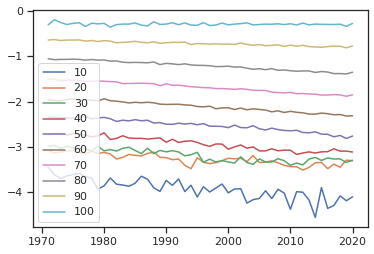

In [32]:
for age in ages[10::10]:
    plt.plot(np.log10(life_exp.loc[age, 'death rates'].iloc[-50:]), label=age)

plt.legend()

In [33]:
life_exp = life_exp.reset_index().set_index(['Year', 'Age'])
life_exp['cumulative life years lost'] = None
life_exp['cumulative predicted life years lost'] = None
life_exp['cumulative deaths'] = None
life_exp['cumulative predicted deaths'] = None

for year in years:
    life_exp['cumulative life years lost'].loc[year] = life_exp.loc[year, 'life years lost'].cumsum().values
    life_exp['cumulative predicted life years lost'].loc[year] = life_exp.loc[year, 'predicted life years lost'].cumsum().values
    life_exp['cumulative deaths'].loc[year] = life_exp.loc[year, 'Deaths'].cumsum().values
    life_exp['cumulative predicted deaths'].loc[year] = life_exp.loc[year, 'predicted deaths'].cumsum().values

/home/rob/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [34]:
life_exp = life_exp.reset_index().set_index(['Year', 'Age'])
life_exp['cumulative adjusted deaths'] = None
for year in years:
    life_exp['cumulative adjusted deaths'].loc[year] = life_exp.loc[year, 'adjusted deaths'].cumsum().values

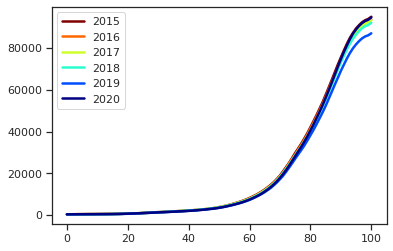

In [35]:
plt.figure()
n = 6
colors = pl.cm.jet(np.linspace(1,0,n))
year=2015
for i in range(n):
    plt.plot(life_exp['cumulative adjusted deaths'].loc[year].values, label=year, color=colors[i], linewidth=2.5)
    year += 1
plt.legend()
plt.show()

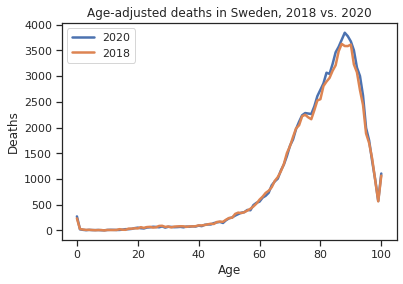

In [36]:
plt.figure()
plt.plot(life_exp['adjusted deaths'].loc[2020].values, label=2020, linewidth=2.5)

plt.plot(life_exp['adjusted deaths'].loc[2018].values, label=2018, linewidth=2.5)
plt.xlabel("Age")
plt.ylabel('Deaths')
plt.legend(loc=2)
plt.title("Age-adjusted deaths in Sweden, 2018 vs. 2020")
plt.savefig("compare_18_20.png")

plt.show()


In [37]:
def plot_expected(year):
    plt.plot(life_exp['Deaths'].loc[year].values, label=year, linewidth=2.5)

    plt.plot(life_exp['predicted deaths'].loc[year].values, label=str(year) + " expected", linewidth=2.5)
    plt.xlabel("Age")
    plt.ylabel('Deaths')
    plt.legend(loc=0)
    plt.title("Expected vs. actual deaths in Sweden, " + str(year) )
    plt.savefig('expected_actual' + str(year) + '.png')

    plt.show()



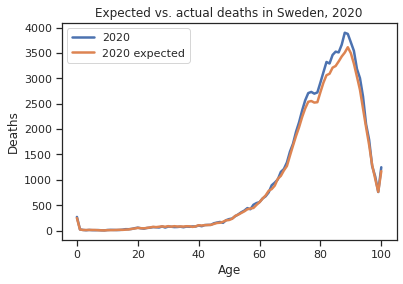

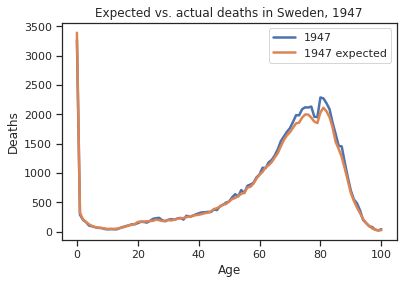

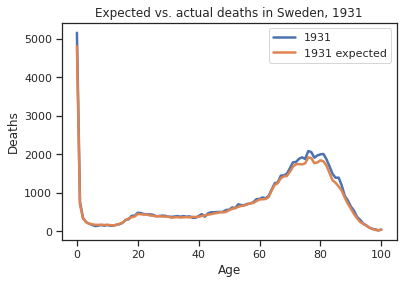

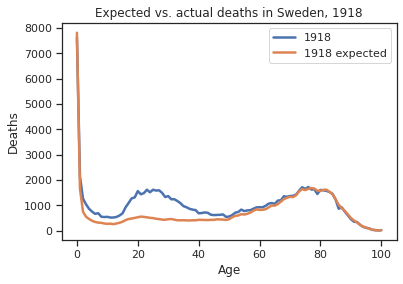

In [38]:
plot_expected(2020)
plot_expected(1947)
plot_expected(1931)
plot_expected(1918)

In [39]:
def cm_plot(year):
    plt.plot(life_exp['cumulative predicted deaths'].loc[year].values, label=str(year)+ ' expected', color=colors[0], linewidth=2.5)
    plt.plot(life_exp['cumulative deaths'].loc[year].values, label=year, color=colors[-1], linewidth=2.5)
    compare = (life_exp['cumulative deaths'].loc[year] > life_exp['cumulative predicted deaths'].loc[year]).values
    plt.xlabel("Age")
    plt.ylabel('Cumulative deaths')
    plt.legend(loc=0)
    plt.title("Cumulative deaths (by age) in Sweden, " + str(year) )

    try:
        switch_year = np.argwhere(compare== False)[-1][0] + 1 # age for which 2020 deaths become greater than 2018
        print(switch_year)
    except:
        pass
    plt.legend()
    plt.savefig("cumulative" + str(year) + ".png")
    plt.show()

12


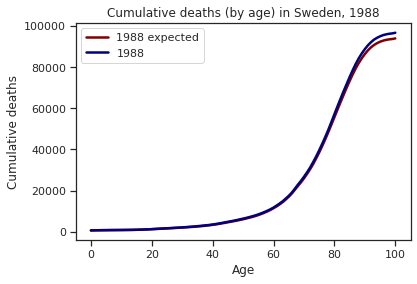

58


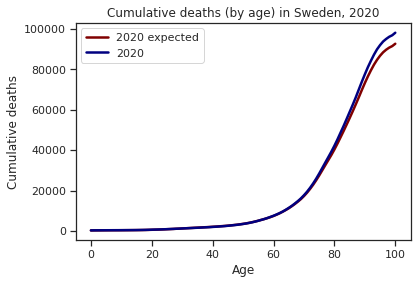

52


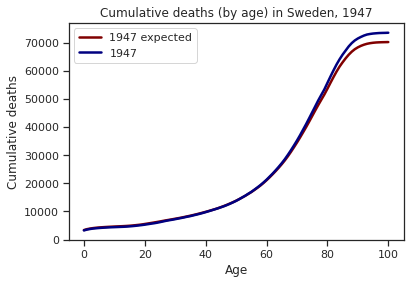

1


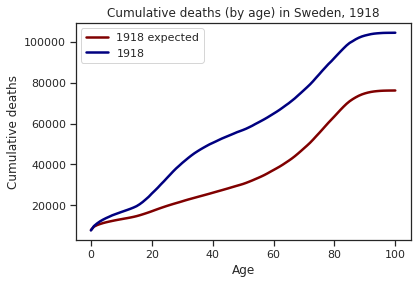

In [40]:
cm_plot(1988)
cm_plot(2020)
cm_plot(1947)
cm_plot(1918)

79


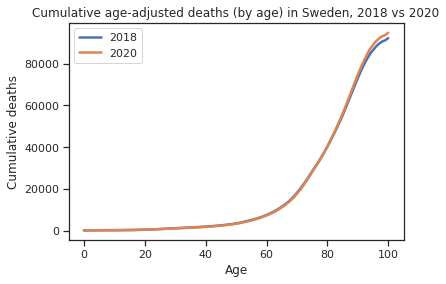

In [41]:
plt.plot(life_exp['cumulative adjusted deaths'].loc[2018].values, label=2018, linewidth=2.5)
plt.plot(life_exp['cumulative adjusted deaths'].loc[2020].values, label=2020, linewidth=2.5)
compare = (life_exp['cumulative adjusted deaths'].loc[2020] > life_exp['cumulative adjusted deaths'].loc[2018]).values
switch_year = np.argwhere(compare== False)[-1][0] + 1 # age for which 2020 deaths become greater than 2018
print(switch_year)
plt.xlabel("Age")
plt.ylabel('Cumulative deaths')
plt.legend(loc=0)
plt.title("Cumulative age-adjusted deaths (by age) in Sweden, 2018 vs 2020")
plt.show()

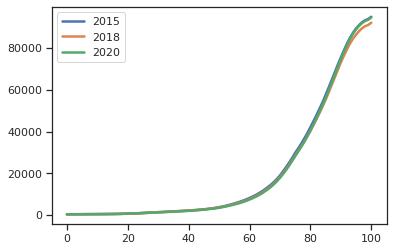

In [42]:
plt.plot(life_exp['cumulative adjusted deaths'].loc[2015].values, label=2015, linewidth=2.5)
plt.plot(life_exp['cumulative adjusted deaths'].loc[2018].values, label=2018, linewidth=2.5)
plt.plot(life_exp['cumulative adjusted deaths'].loc[2020].values, label=2020, linewidth=2.5)
year += 1
compare = (life_exp['cumulative adjusted deaths'].loc[2020] > life_exp['cumulative adjusted deaths'].loc[2018]).values
switch_year = np.argwhere(compare== False)[-1][0] + 1 # age for which 2020 deaths become greater than 2018
#plt.plot(life_exp['cumulative adjusted deaths'].loc[2020].values, label=2020, color=colors[-1], linewidth=2.5)
plt.legend()
plt.show()

In [43]:
switch_year

79

In [44]:
life_exp_agg['excess deaths'].iloc[-10:]

Year
2011    -873.319806
2012    1289.509068
2013    -194.279756
2014   -1859.863373
2015    -197.420743
2016    -357.618992
2017     412.726868
2018     406.874549
2019   -3572.520317
2020    5446.652857
Name: excess deaths, dtype: float64